# Part 1: Data Exploration and Preprocessing

In this notebook, you will implement functions to load, preprocess, and visualize physiological data from the Wearable Exam Stress Dataset.

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from pathlib import Path
import os

# Set style for plots
plt.style.use('seaborn')
%matplotlib inline

/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3702442187.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


## 1. Data Loading

Implement the `load_data` function to read and organize the physiological data from the dataset.

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

def load_signal(filepath):
    df = pd.read_csv(filepath, header=None)
    start_time = df.iloc[0, 0]
    sample_rate = float(df.iloc[1, 0])
    values = df.iloc[2:].reset_index(drop=True).astype(float)
    timestamps = pd.to_datetime(start_time, unit='s') + pd.to_timedelta(np.arange(len(values)) / sample_rate, unit='s')
    return timestamps, values

def load_session(hr_path, eda_path, temp_path, subject_id, session):
    hr_times, hr_values = load_signal(hr_path)
    eda_times, eda_values = load_signal(eda_path)
    temp_times, temp_values = load_signal(temp_path)

    min_len = min(len(hr_times), len(eda_times), len(temp_times))

    df = pd.DataFrame({
        'timestamp': hr_times[:min_len],
        'heart_rate': hr_values.iloc[:min_len, 0],
        'eda': eda_values.iloc[:min_len, 0],
        'temperature': temp_values.iloc[:min_len, 0],
        'subject_id': subject_id,
        'session': session
    })

    return df

base_dir = Path('/Users/hteshome/Desktop/4-it-s-about-time-haile-teshome/Data')

all_data = []


for subject_folder in base_dir.glob('S*'):
    subject_id = subject_folder.name 

    for session_folder_name in ['Final', 'Midterm 1', 'Midterm 2']:
        session_folder = subject_folder / session_folder_name

        if session_folder.exists():
            try:
                hr_path = session_folder / 'HR.csv'
                eda_path = session_folder / 'EDA.csv'
                temp_path = session_folder / 'TEMP.csv'

                session_data = load_session(hr_path, eda_path, temp_path, subject_id, session_folder_name)
                all_data.append(session_data)

                print(f"Loaded: {subject_id} - {session_folder_name}")

            except Exception as e:
                print(f"Failed to load {subject_id} - {session_folder_name}: {e}")
        else:
            print(f"Missing folder: {session_folder}")

# Combine everything
combined_data = pd.concat(all_data, ignore_index=True)

print("Shape:", combined_data.shape)
print("Subjects:", combined_data['subject_id'].unique())
print("Sessions:", combined_data['session'].unique())






Loaded: S5 - Final
Loaded: S5 - Midterm 1
Loaded: S5 - Midterm 2
Loaded: S2 - Final
Loaded: S2 - Midterm 1
Loaded: S2 - Midterm 2
Loaded: S3 - Final
Loaded: S3 - Midterm 1
Loaded: S3 - Midterm 2
Loaded: S4 - Final
Loaded: S4 - Midterm 1
Loaded: S4 - Midterm 2
Loaded: S10 - Final
Loaded: S10 - Midterm 1
Loaded: S10 - Midterm 2
Loaded: S8 - Final
Loaded: S8 - Midterm 1
Loaded: S8 - Midterm 2
Loaded: S1 - Final
Loaded: S1 - Midterm 1
Loaded: S1 - Midterm 2
Loaded: S6 - Final
Loaded: S6 - Midterm 1
Loaded: S6 - Midterm 2
Loaded: S7 - Final
Loaded: S7 - Midterm 1
Loaded: S7 - Midterm 2
Loaded: S9 - Final
Loaded: S9 - Midterm 1
Loaded: S9 - Midterm 2
Shape: (443002, 6)
Subjects: ['S5' 'S2' 'S3' 'S4' 'S10' 'S8' 'S1' 'S6' 'S7' 'S9']
Sessions: ['Final' 'Midterm 1' 'Midterm 2']


## 2. Data Preprocessing

Implement the `preprocess_data` function to clean and prepare the data for analysis.

In [3]:
def preprocess_data(data, output_dir='processed_data'):
    """
    Preprocess physiological data:
    - Handle missing values
    - Resample to regular intervals
    - Remove outliers
    - Save processed data per subject
    
    Args:
        data (pd.DataFrame): Combined raw data
        output_dir (str): Directory to save processed files
        
    Returns:
        pd.DataFrame: Clean processed combined data
    """
    from pathlib import Path
    from scipy import stats
    import os

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    print("\nPreprocessing data...")
    processed_subjects = []

    data = data.sort_values(by=['subject_id', 'session', 'timestamp'])
    data.interpolate(method='linear', inplace=True, limit_direction='forward')
    data.fillna(method='ffill', inplace=True)

    for col in ['heart_rate', 'eda', 'temperature']:
        z_scores = np.abs(stats.zscore(data[col]))
        data = data[z_scores < 3.5]

    for subject_id, subject_group in data.groupby('subject_id'):
        subject_processed = []

        for session, session_group in subject_group.groupby('session'):
            session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
            session_group['subject_id'] = subject_id
            session_group['session'] = session
            subject_processed.append(session_group.reset_index())


        subject_df = pd.concat(subject_processed, ignore_index=True)
        processed_subjects.append(subject_df)
        subject_file = output_dir / f"{subject_id}_processed.csv"
        subject_df.to_csv(subject_file, index=False)
        print(f"Saved: {subject_file}")

    processed_data = pd.concat(processed_subjects, ignore_index=True)
    print("\nPreprocessing complete!")
    print("Processed shape:", processed_data.shape)
    return processed_data



## 3. Visualization

Implement the `plot_physiological_signals` function to create visualizations of the physiological data.

In [4]:
import matplotlib.pyplot as plt
from pathlib import Path

def plot_physiological_signals(data, subject_id, session, output_dir='plots'):
    """
    Plot physiological signals for a given subject and session.
    
    Args:
        data (pd.DataFrame): Processed data.
        subject_id (str): Subject ID (e.g., 'S1').
        session (str): Session name ('Final', 'Midterm 1', 'Midterm 2').
        output_dir (str): Directory to save plots.
        
    Returns:
        matplotlib.figure.Figure: The plot figure object.
    """
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    subset = data[(data['subject_id'] == subject_id) & (data['session'] == session)]

    if subset.empty:
        print(f"No data found for {subject_id} - {session}")
        return None

    fig, axs = plt.subplots(3, 1, figsize=(14, 10), sharex=True)

    axs[0].plot(subset['timestamp'], subset['heart_rate'], label='Heart Rate (bpm)')
    axs[0].set_ylabel('Heart Rate (bpm)')
    axs[0].legend()
    axs[0].grid(True)
    axs[1].plot(subset['timestamp'], subset['eda'], color='orange', label='EDA (μS)')
    axs[1].set_ylabel('EDA (μS)')
    axs[1].legend()
    axs[1].grid(True)
    axs[2].plot(subset['timestamp'], subset['temperature'], color='green', label='Temperature (°C)')
    axs[2].set_ylabel('Temperature (°C)')
    axs[2].legend()
    axs[2].grid(True)
    fig.suptitle(f'Physiological Signals - {subject_id} - {session}', fontsize=16)
    fig.autofmt_xdate()

    plot_filename = output_dir / f"{subject_id}_{session.replace(' ', '_')}_signals.png"
    fig.savefig(plot_filename)

    print(f"Plot saved to {plot_filename}")
    plt.close(fig)
    return fig



Preprocessing data...


/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:27: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  data.interpolate(method='linear', inplace=True, limit_direction='forward')
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:28: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data.fillna(method='ffill', inplace=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be remo

Saved: processed_data/S1_processed.csv
Saved: processed_data/S10_processed.csv


/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' ins

Saved: processed_data/S2_processed.csv
Saved: processed_data/S3_processed.csv


/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' ins

Saved: processed_data/S4_processed.csv
Saved: processed_data/S5_processed.csv
Saved: processed_data/S6_processed.csv


/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' ins

Saved: processed_data/S7_processed.csv
Saved: processed_data/S8_processed.csv
Saved: processed_data/S9_processed.csv

Preprocessing complete!
Processed shape: (442247, 6)

Preprocessing finished
Processed shape : (442247, 6)
First few rows :


/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' instead.
  session_group = session_group.set_index('timestamp').resample('1S').mean(numeric_only=True)
/var/folders/91/318xx77d4wbb95s3dsdtsshc0000gq/T/ipykernel_27283/3875360091.py:38: FutureWarning: 'S' is deprecated and will be removed in a future version, please use 's' ins

,timestamp,heart_rate,eda,temperature,subject_id,session
0,2018-12-05 16:29:07,116.00,0.000000,21.89,S1,Final
1,2018-12-05 16:29:08,82.50,0.005125,21.89,S1,Final
2,2018-12-05 16:29:09,96.33,0.020501,21.89,S1,Final
3,2018-12-05 16:29:10,86.25,0.021783,21.89,S1,Final
4,2018-12-05 16:29:11,98.60,0.023064,21.89,S1,Final



Unique subjects : ['S1' 'S10' 'S2' 'S3' 'S4' 'S5' 'S6' 'S7' 'S8' 'S9']
Unique sessions : ['Final' 'Midterm 1' 'Midterm 2']
Plot saved to plots/S1_Final_signals.png


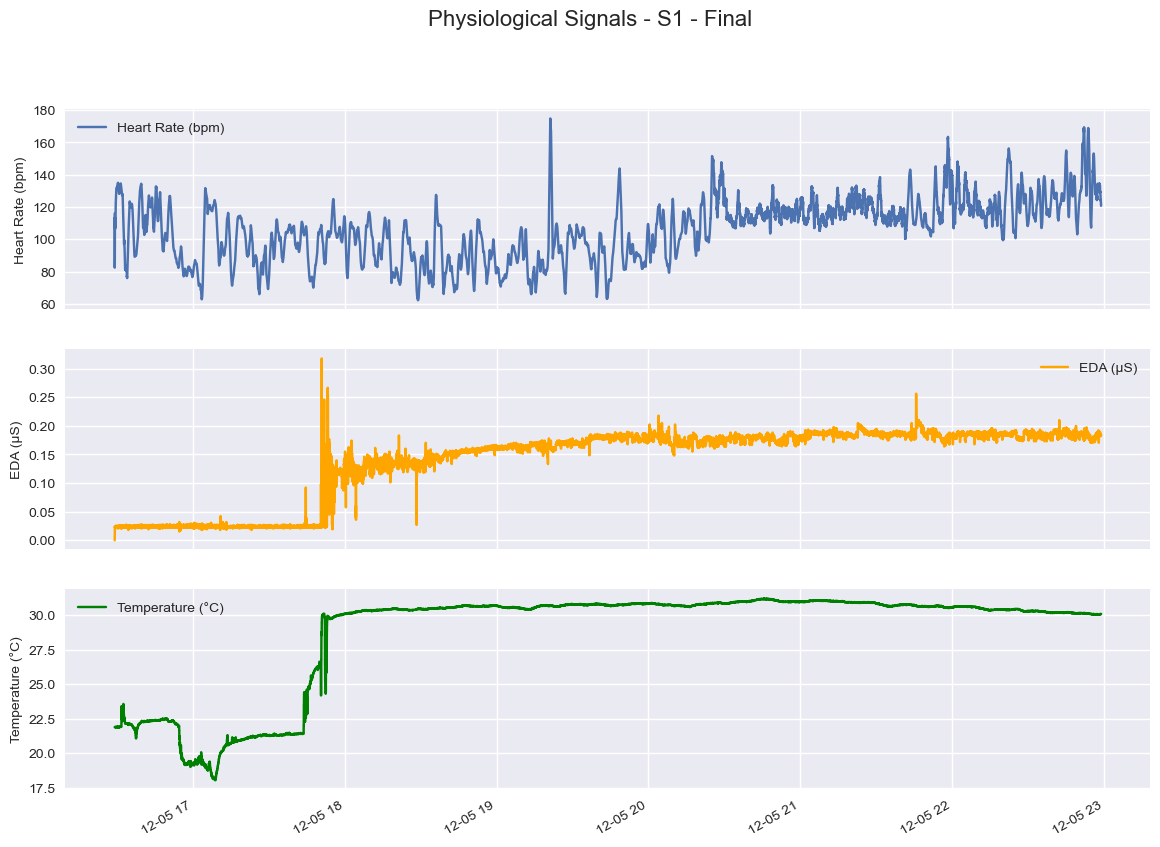

In [9]:
processed_data = preprocess_data(combined_data, output_dir="processed_data")

print("\nPreprocessing finished")
print("Processed shape :", processed_data.shape)
print("First few rows :")
display(processed_data.head())        


print("\nUnique subjects :", processed_data['subject_id'].unique())
print("Unique sessions :", processed_data['session'].unique())

subject_id = processed_data['subject_id'].iloc[0]
session    = processed_data['session'].iloc[0]

fig = plot_physiological_signals(
    processed_data,
    subject_id=subject_id,
    session=session,
    output_dir="plots"
)

display(fig)
